# Поставленные задачи

#### Целевая переменная
Credit Default - факт невыполнения кредитных обязательств

#### Метрика качества
F1-score (sklearn.metrics.f1_score)

#### Требования к решению
* Целевая метрика: F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

#### Решение должно содержать
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv

#### Рекомендации для файла с кодом (ipynb)
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

#### Сроки сдачи
Cдать проект нужно в течение 5 дней после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

# Загрузка всего необходимого

In [1]:
import pandas as pd  # для работы с данными
from matplotlib import pyplot as plt  # для построения граффиков
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [2]:
df_train = pd.read_csv('course_project_train.csv')  # обучающий датасет
df_test = pd.read_csv('course_project_test.csv')  # тестовый датасет

In [3]:
# Настройка оценки качества прогноза

def chek_result(y_test, y_pred):
    f1 = f1_score(y_test, y_pred, pos_label=1)
    #print(f'Точность прогноза составляется: {f1}')
    return f1

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred): 
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

# Обзор обучающего датасета

#### Описание датасета

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Прежде всего необходимо привести все данные к единому типу

In [5]:
df_t = df_train.copy()
for c in df_t.select_dtypes(include=['object']).columns:
    for j, i in enumerate(df_t[c].value_counts().index):
        df_t.loc[df_t[c] == i, c] = j
        
for c in df_t.select_dtypes(exclude=['float64']).columns:
    df_t = df_t.astype({c: np.float64})

for c in df_t.columns:
    df_t.loc[df_t[c].isna(), c] = 0

In [6]:
df_t = df_train.copy()
for c in df_t.select_dtypes(include=['object']).columns:
    for i in df_t[c].value_counts().index:
        df_t[i] = 0.0
        df_t.loc[df_t[c] == i, i] = 0.1
    df_t = df_t.drop(columns = c)
    
for c in df_t.select_dtypes(exclude=['float64']).columns:
    df_t = df_t.astype({c: np.float64})

for c in df_t.columns:
    df_t.loc[df_t[c].isna(), c] = 0

далее выявим выбросы у не категориальных элементов

In [7]:
c = df_t.columns
columns = [c[1], c[3], c[4], c[5], c[6], c[7], c[8], c[9], c[12], c[13], c[14], c[15]]

df_t[columns].describe().T


,count,mean,std,min,25%,50%,75%,max
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,7500.0,1.581520e+01,2.264944e+01,0.0,0.0,0.0,29.00,1.180000e+02
Bankruptcies,7500.0,1.169333e-01,3.469044e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06
Credit Default,7500.0,2.817333e-01,4.498740e-01,0.0,0.0,0.0,1.00,1.000000e+00
Home Mortgage,7500.0,4.849333e-02,4.998063e-02,0.0,0.0,0.0,0.10,1.000000e-01


Уделим особое внимание следующим признакам

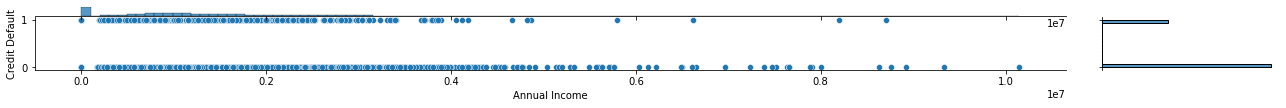

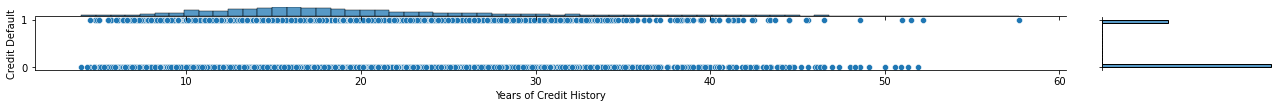

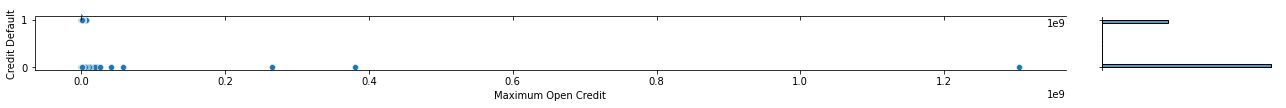

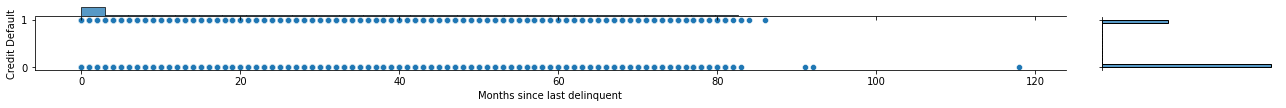

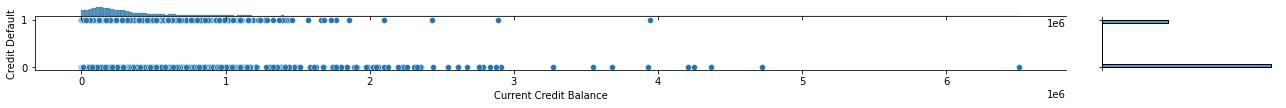

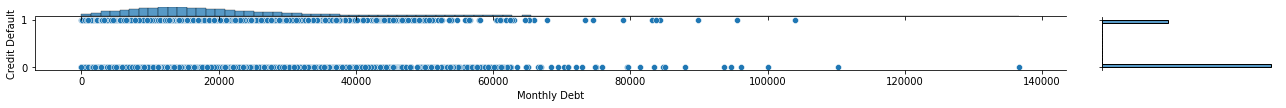

In [8]:
for i in ['Annual Income', 
          'Years of Credit History', 
          'Maximum Open Credit', 
          'Months since last delinquent', 
          'Current Credit Balance', 
          'Monthly Debt']:
    grid = sns.jointplot(data=df_t, x=i, y='Credit Default')
    grid.fig.set_figwidth(20)
    grid.fig.set_figheight(1)

как видим на высоких значениях встречаются выбросы, почистим их

In [9]:
df_t = df_t.loc[df_t['Annual Income']< 0.4*(10**7)]
df_t = df_t.loc[df_t['Years of Credit History']> 5]
df_t = df_t.loc[df_t['Years of Credit History']< 45]
df_t = df_t.loc[df_t['Maximum Open Credit']< 0.1*(10**7)]
df_t = df_t.loc[df_t['Months since last delinquent']< 100]
df_t = df_t.loc[df_t['Current Credit Balance']< 6*(10**5)]
df_t = df_t.loc[df_t['Monthly Debt']< 4*(10**4)]

построим модель

In [10]:
y = df_t.pop('Credit Default')
x = df_t
x = normalize(df_t, norm='l2', axis=1, copy=True, return_norm=False)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, shuffle = True)

model = CatBoostClassifier(eval_metric = 'F1',
                           iterations = 1400,
                           random_seed = 50,
                           border_count = 120,
                           learning_rate = 0.624,
                           score_function = 'Cosine',                           
                           bootstrap_type = 'Bayesian',
                           silent=True)
model.fit(x_train, y_train) 
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
y_test_pred_probs = model.predict_proba(x_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2957
         1.0       1.00      1.00      1.00      1225

    accuracy                           1.00      4182
   macro avg       1.00      1.00      1.00      4182
weighted avg       1.00      1.00      1.00      4182

TEST

              precision    recall  f1-score   support

         0.0       0.79      0.87      0.82      1284
         1.0       0.54      0.41      0.47       509

    accuracy                           0.74      1793
   macro avg       0.67      0.64      0.64      1793
weighted avg       0.72      0.74      0.72      1793

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1111  173
1.0              302  207


In [11]:
model.feature_importances_
feature_importances = pd.DataFrame({'feature': df_t.columns, 'importance': model.feature_importances_})

important_features_top = feature_importances.loc[feature_importances['importance'] >2, 'feature'].tolist()

In [12]:
x = df_t[important_features_top]
x = normalize(df_t, norm='l2', axis=1, copy=True, return_norm=False)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, shuffle = True)

final_model = CatBoostClassifier(eval_metric = 'F1',
                           iterations = 1400,
                           random_seed = 50,
                           border_count = 120,
                           learning_rate = 0.624,
                           score_function = 'Cosine',                           
                           bootstrap_type = 'Bayesian',
                           silent=True)
model.fit(x_train, y_train) 
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
y_test_pred_probs = model.predict_proba(x_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2998
         1.0       1.00      1.00      1.00      1184

    accuracy                           1.00      4182
   macro avg       1.00      1.00      1.00      4182
weighted avg       1.00      1.00      1.00      4182

TEST

              precision    recall  f1-score   support

         0.0       0.77      0.89      0.83      1243
         1.0       0.63      0.41      0.50       550

    accuracy                           0.74      1793
   macro avg       0.70      0.65      0.66      1793
weighted avg       0.73      0.74      0.73      1793

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1109  134
1.0              324  226


In [36]:
result_df = pd.DataFrame(x_test, columns = df_t.columns)
result_df['Credit Default'] = y_test_pred
result_df.to_csv('СЮАнуфриев_predictions.csv', sep='\t', encoding='utf-8')